In [106]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats

# Increase Confidence

In [107]:
# === OvA ===
n_classes = 10
random_expert_idx = 0
confs = []
exps = []
true = []
path = "ova_increase_confidence/"
n_experts = 4
p_experts = [0.2, 0.4, 0.6, 0.8, 0.95]
for p in p_experts:
    model_name = '_' + str(p) + '_confidence'
    with open(path + 'confidence_multiple_experts' + model_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

In [108]:
# 1 expert rando, 3 with prob 0.8 correct
probs = confs[-1]
experts = exps[-1]
experts = experts[::-1]  # reverse order!
y_true = true[-1]

In [109]:
probs[:5,10:]

tensor([[0.9570, 0.9604, 0.9513, 0.1061],
        [0.2967, 0.2311, 0.2523, 0.0976],
        [0.3738, 0.3407, 0.3525, 0.1129],
        [0.9599, 0.9614, 0.9593, 0.1075],
        [0.2650, 0.2876, 0.2489, 0.0850]])

In [110]:
np.array(experts)

array([[3, 2, 8, ..., 2, 5, 5],
       [3, 8, 2, ..., 5, 0, 5],
       [3, 5, 3, ..., 4, 9, 5],
       [6, 6, 0, ..., 7, 5, 3]])

In [111]:
y_true[:5]

[3, 8, 8, 0, 6]

In [112]:
n_val = int(0.8 * len(y_true))
n_test = len(y_true) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


In [113]:
probs[n_val:, 10:][:5]

tensor([[0.9446, 0.9549, 0.9215, 0.1244],
        [0.9760, 0.9769, 0.9756, 0.1037],
        [0.9622, 0.9661, 0.9566, 0.1071],
        [0.5943, 0.6163, 0.6032, 0.1009],
        [0.9769, 0.9751, 0.9695, 0.1257]])

# Validation

In [114]:
## 2. get Q_hat

n_classes_exp = n_classes + n_experts
probs_val = probs[:n_val, 10:]

# experts_val = experts[::-1]  # IMPORTANT! swap to match prob ordering
experts_val = experts
experts_val = [exp[:n_val] for exp in experts_val]

y_true_val = y_true[:n_val]

# === Only on deferred samples
_, predicted = torch.max(probs[:n_val].data, 1)
r = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_val = probs_val[r]
experts_val = [np.array(exp)[r] for exp in experts_val]
y_true_val = np.array(y_true_val)[r]

# Model expert probs ===
# Sort J model outputs for experts
probs_experts = probs[:n_val, 10:]
probs_experts = probs_experts[r]
sort, pi = probs_experts.sort(dim=1, descending=True)

# Correctness experts ===
# Check if experts are correct 
correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
# idx for correct experts: [[0,1,2], [1,2], [], ...]
correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

# obtain the last expert to be retrieved. If empty, then add all values.
# indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

# obtain real expert index back, e.g. [2,1,-1,...]
pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]


# =========
n_val = n_val
alpha = 0.1
scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
qhat = torch.quantile(scores, np.ceil((r.sum() + 1) * (1 - alpha)) / r.sum(), interpolation="higher")

qhat

tensor(2.8904)

In [115]:
r.sum()

tensor(1443)

# Test

In [116]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:, n_classes:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [117]:
# === Only on deferred samples
_, predicted = torch.max(probs[n_val:].data, 1)
r_test = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_test = probs_test[r_test]
experts_test = [np.array(exp)[r_test] for exp in experts_test]
y_true_test = np.array(y_true_test)[r_test]

# Sort J model outputs for experts. sorted probs and sorted indexes
sort_test, pi_test = probs_test.sort(dim=1, descending=True)
# Get last sorted index to be below Q_hat
pi_stop = (sort_test.cumsum(dim=1) <= qhat).sum(axis=1)

# Prediction sets
prediction_sets = [(pi_test[i][:(pi_stop[i])]).numpy() for i in range(pi_stop.shape[0])]  # not allow empty sets
prediction_sets[:5]

[array([1, 0, 2, 3]),
 array([1, 0]),
 array([2, 0, 1, 3]),
 array([1, 2, 0, 3]),
 array([1, 2, 0])]

In [118]:
r.sum()/len(r)

tensor(0.1957)

<AxesSubplot:ylabel='Count'>

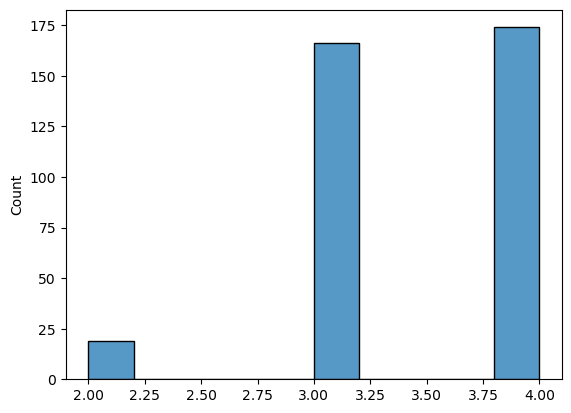

In [119]:
a = np.array([len(prediction_sets_i) for prediction_sets_i in prediction_sets])
import seaborn as sns

sns.histplot(a)

# Accuracy

### Accuracy w/o Conformal on deferred samples

In [120]:
correct = 0
correct_sys = 0
exp = 0
exp_total = 0
total = 0
real_total = 0
alone_correct = 0
#  === Individual Expert Accuracies === #
expert_correct_dic = {k: 0 for k in range(len(experts_test))}
expert_total_dic = {k: 0 for k in range(len(experts_test))}

In [121]:
# 1 expert rando, 3 with prob 0.9 correct
probs = confs[-1]
experts = exps[-1]
experts = experts[::-1] 
y_true = true[-1]

In [122]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [123]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

### w Conformal Prediction

In [124]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)
for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    if r == 1:
        # Conformal prediction ===        
        # Sort J model outputs for experts. sorted probs and sorted indexes
        sort_i, pi_i = probs_test[i,n_classes:].sort(descending=True)
        # Get last sorted index to be below Q_hat
        pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()

        # Prediction sets
        prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        
        
        ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode
        # Conformal prediction ===
        
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        exp_total += 1
        # Individual Expert Accuracy ===
        # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
        # expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1
    
#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}






In [125]:
print("Cov: {}".format(100 * (total/real_total)))

Cov: 80.53145336225597


In [126]:
expert_accuracies

{'expert_0': 0.0, 'expert_1': 0.0, 'expert_2': 0.0, 'expert_3': 0.0}

In [127]:
100 * exp / (exp_total + 0.0002),

(array([86.35092682]),)

In [128]:
exp_total

359

In [129]:
100 * correct_sys / real_total

array([91.75704989])

### w/o Conformal Prediction

In [130]:
correct = 0
correct_sys = 0
exp = 0
exp_total = 0
total = 0
real_total = 0
alone_correct = 0
#  === Individual Expert Accuracies === #
expert_correct_dic = {k: 0 for k in range(len(experts_test))}
expert_total_dic = {k: 0 for k in range(len(experts_test))}

In [131]:
# 1 expert rando, 3 with prob 0.9 correct
probs = confs[-1]
experts = exps[-1]
experts = experts[::-1] 
y_true = true[-1]

In [132]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [133]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

In [134]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)
for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    if r == 1:
        deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
        # deferred_exp = ((n_classes - 1) - predicted[i]).item()  # reverse order, as in loss function
        exp_prediction = experts_test[deferred_exp][i]
        #
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        exp_total += 1
        # Individual Expert Accuracy ===
        expert_correct_dic[deferred_exp] += (exp_prediction == labels[i])
        expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1
    
#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}






In [135]:
deferred_exp

1

In [136]:
print("Cov: {}".format(100 * (total/real_total)))

Cov: 80.53145336225597


In [137]:
expert_accuracies

{'expert_0': 74.9990625117186,
 'expert_1': 83.64306048843086,
 'expert_2': 72.97277574925472,
 'expert_3': 0.0}

In [138]:
100 * exp / (exp_total + 0.0002),

(81.05845066381579,)

In [139]:
exp

291

In [140]:
100 * correct_sys / real_total

90.72668112798264

### Accuracy w Conformal on deferred samples

In [141]:
qhat

tensor(2.8904)

In [142]:
probs_test[:,10:]

tensor([[0.9446, 0.9549, 0.9215, 0.1244],
        [0.9760, 0.9769, 0.9756, 0.1037],
        [0.9622, 0.9661, 0.9566, 0.1071],
        ...,
        [0.9315, 0.9366, 0.9419, 0.1079],
        [0.2346, 0.2542, 0.2841, 0.1010],
        [0.9251, 0.9364, 0.9127, 0.1279]])